In [ ]:
import xarray as xr
import rioxarray
import re
from datetime import datetime
from glob import glob
import numpy as np

# 获取 NBAR 和 footprint 文件列表
nbar_ls = glob('PF-SR/*.tif')
footprint_ls = glob('tiffs_MON/*.tif')

# 创建空字典来存储每月的 NBAR 和 footprint 数据
nbar_monthly = {}
footprint_monthly = {}

# 分类 NBAR 数据
for filename in nbar_ls:
    date = re.search(r'\d{4}-\d{2}-\d{2}', filename).group(0)
    date = datetime.strptime(date, '%Y-%m-%d')
    month = date.strftime('%Y-%m')
    if month not in nbar_monthly:
        nbar_monthly[month] = []
    nbar_monthly[month].append(filename)

# 分类 footprint 数据
for filename in footprint_ls:
    date = re.search(r'\d{4}-\d{2}-\d{2}', filename).group(0)
    date = datetime.strptime(date, '%Y-%m-%d')
    month = date.strftime('%Y-%m')
    if month not in footprint_monthly:
        footprint_monthly[month] = []
    footprint_monthly[month].append(filename)
ls = []
# 处理每个月份的数据
for month, nbar_files in nbar_monthly.items():
    if month not in footprint_monthly:
        print(f"缺少 {month} 的 footprint 数据，跳过此月份")
        continue

    # 计算每个月的 NIRV 平均值
    nirv_monthly = []
    for nbar_filename in nbar_files:
        nbar = xr.open_dataset(nbar_filename, engine="rasterio")
        # 取每个月的第一个 footprint 文件
        footprint_filename = footprint_monthly[month][0]
        footprint = xr.open_dataset(footprint_filename, engine="rasterio").squeeze()['band_data']
        nbar_matched = nbar.rio.reproject_match(footprint, resampling=0)
        nbar_matched.to_netcdf(f'nbar_small_region/nbar_matched_{month}.nc')
        nirv = (nbar_matched.sel(band=4) * (nbar_matched.sel(band=4) - nbar_matched.sel(band=3)) / (nbar_matched.sel(band=4) + nbar_matched.sel(band=3)))['band_data']/10000
        nirv_monthly.append(nirv)

    # 计算平均值，并应用 footprint 掩模
    nirv_avg = sum(nirv_monthly) / len(nirv_monthly)
    nirv_masked = nirv_avg * footprint
    ls.append([month,nirv_masked.mean().values,nirv_masked.std().values,nirv_masked.quantile(.75).values,nirv_masked.quantile(.25).values,nirv_masked.max().values,nirv_masked.min().values])
    # 可以在此处保存或处理 nirv_masked
    # 例如：nirv_masked.to_netcdf(f'nirv_{month}.nc')


ERROR 1: TIFFFillTile:Read error at row 4864, col 4864, tile 372; got 213276 bytes, expected 329556
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: PF-SR/2018-01-03.tif, band 1: IReadBlock failed at X offset 20, Y offset 11: TIFFReadEncodedTile() failed.


RasterioIOError: Read or write failed. PF-SR/2018-01-03.tif, band 1: IReadBlock failed at X offset 20, Y offset 11: TIFFReadEncodedTile() failed.

In [ ]:

nir_within_footprint = pd.DataFrame(ls, columns=['month', 'mean', 'std','75-th quantile','25-th quantile','max','min']).set_index('month')
nir_within_footprint.index = pd.to_datetime(nir_within_footprint.index)

In [ ]:
df = nir_within_footprint.astype(dtype='float')

In [3]:
# df.resample('M').mean().to_csv('nirv_within_footprint.csv')
import pandas as pd
pd.read_csv('nirv_within_footprint.csv',index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'nirv_within_footprint.csv'

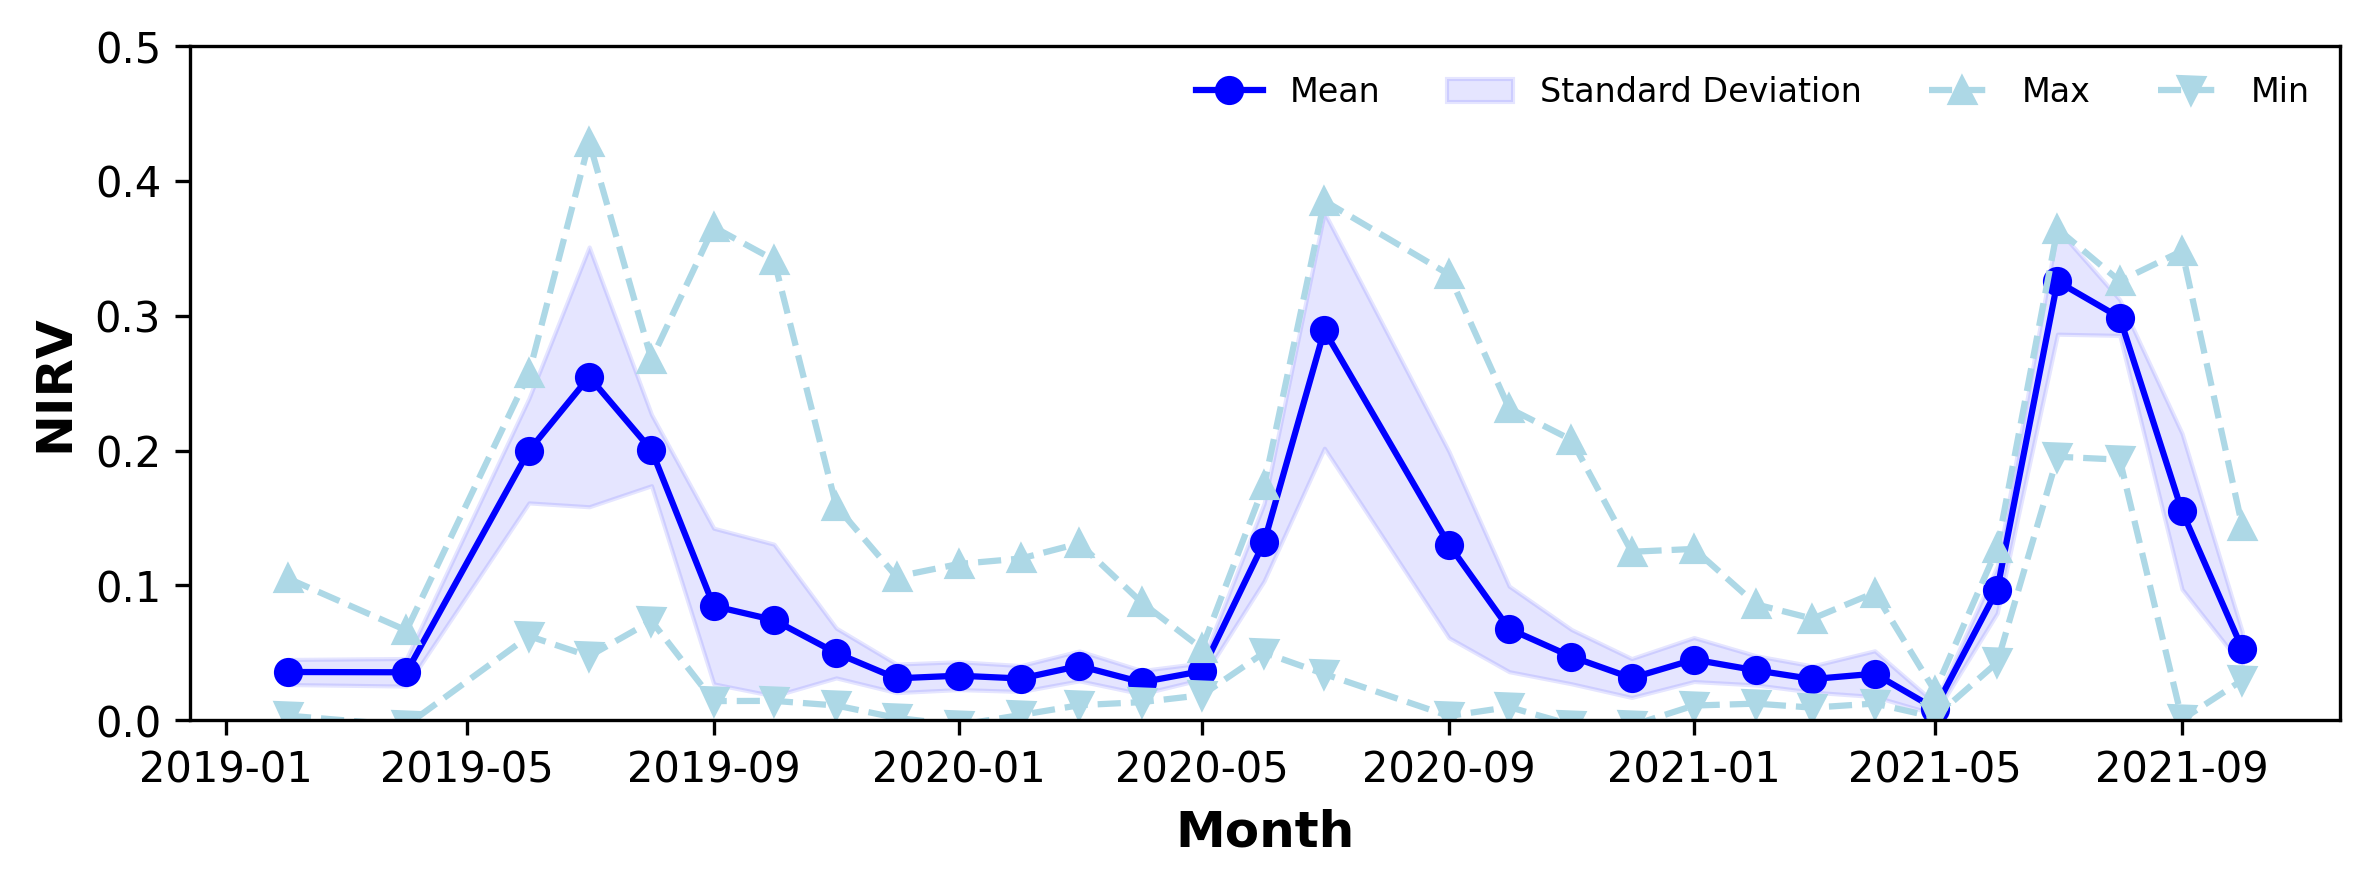

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Assuming df is your DataFrame and it's already been loaded correctly.

# Calculate the upper and lower bounds for the standard deviation
df['upper'] = df['mean'] + df['std']
df['lower'] = df['mean'] - df['std']

# Set the style of the plot to be Nature-like
plt.style.use('default')
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 3), dpi=300)

# Plotting the mean, standard deviation, and quantiles
ax.plot(df.index, df['mean'], marker='o', color='blue', label='Mean')
ax.fill_between(df.index, df['upper'], df['lower'], color='blue', alpha=0.1, label='Standard Deviation')
ax.plot(df.index, df['max'], marker='^', color='lightblue', ls ='--', label='Max')
ax.plot(df.index, df['min'], marker='v', color='lightblue', ls ='--', label='Min')

# Plotting max and min as scatter points
# ax.scatter(df.index, df['max'], color='grey', label='Max', s=5)
# ax.scatter(df.index, df['min'], color='orange', label='Min', s=5)

# Setting the date format on the x-axis
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# ax.xaxis.set_major_locator(mdates.MonthLocator())

# Improve the tick marks
ax.xaxis.set_tick_params( labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Setting labels and title with a larger font
ax.set_xlabel('Month', fontsize=12, weight='bold')
ax.set_ylabel('Values', fontsize=12, weight='bold')
# ax.set_title('Time Series Analysis: February and April 2019', fontsize=14, weight='bold')

# Adding a legend with a frame and without overlapping the plot
ax.legend(frameon=False, loc='upper right', fontsize=8,ncols=6)

# Tight layout to ensure nothing is clipped
plt.tight_layout()
# make more space for y axis
# plt.subplots_adjust( top=.5)
# # Saving the figure with a transparent background
# plt.savefig('/mnt/data/time_series_analysis.png', format='png', transparent=True)
plt.ylim(0,0.5)
plt.ylabel(ylabel='NIRV',fontsize=12, weight='bold')
# Show the plot
plt.show()


In [ ]:
nbar_matched = nbar.rio.reproject_match(footprint,resampling=0)
nirv = (nbar_matched.sel(band=4) * (nbar_matched.sel(band=4) - nbar_matched.sel(band=3)) / (nbar_matched.sel(band=4) + nbar_matched.sel(band=3)))['band_data']/10000

In [ ]:
footprint

In [ ]:
(nirv*footprint).plot.imshow(robust=True)

In [ ]:
nbar_matched.sel(band=[3,2,1])['band_data'].plot.imshow(robust=True)

In [ ]:
nbar_matched.sel(band=1).squeeze()['band_data'].plot.imshow()

In [ ]:
(nbar_matched*footprint).sel(band=1).squeeze()['band_data'].plot.imshow()

In [ ]:
import rioxarray
import rasterio

# 读取参考 TIFF 图像以获取 CRS 和地理变换
with rasterio.open('nbar_3m/CRK.tif') as ref_tif:
    crs = ref_tif.crs
    ref_transform = ref_tif.transform
    ref_width = ref_tif.width
    ref_height = ref_tif.height

# 读取 PNG 图像以获取其尺寸
with rasterio.open('nbar_3m/Sentinel2_NBAR_20190103_out.png') as png_tif:
    png_width = png_tif.width
    png_height = png_tif.height

# 计算新的地理变换
# 假设 PNG 图像具有更高的分辨率，但覆盖相同的地理范围
scale_x = ref_width / png_width
scale_y = ref_height / png_height
new_transform = rasterio.Affine(ref_transform.a * scale_x, ref_transform.b, ref_transform.c,
                                ref_transform.d, ref_transform.e * scale_y, ref_transform.f)

# 使用 rioxarray 读取 PNG 图像
png_3m = rioxarray.open_rasterio('nbar_3m/Sentinel2_NBAR_20190103_out.png')

# 将新的地理变换和 CRS 应用于 PNG 图像
png_3m.rio.write_transform(new_transform, inplace=True)
png_3m.rio.write_crs(crs.to_string(), inplace=True)

# png_3m 现在是一个带有地理坐标的 xarray 数据集


In [ ]:
png_3m.plot